# NBA Most Improved Player prediction


<p>Every year an award is given to the player who has made sufficient improvement over the course of the regular season. The award is voted on by a set of votees close to the league. This is an attempt to produce a model that can provide a list of worthy recipients of the award.</p>
<p>The historical season stat data was scraped from Basketball Reference, and the award data from Wikipedia. Note that the award was only awarded from the 1991-92 season so we will only go back that far.</p>
<p>The algorithms used are Random Forest and KNN (K Nearest Neighbors). There is probably a more straight forward method to use (linear regression) but the purpose of this exercise was to get familiar with these two algorithms.</p>

### Import the required modules.

In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 
import seaborn as sns
%matplotlib inline

### Scrape Basketball reference. 

In [2]:
#We'll start from 1990/1991 Season to 2016/2017
#Pull all player data and clean
full_player_data = pd.DataFrame()
for i in range(1991,2018):
    url = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html'.format(i)
    html = urlopen(url)
    soup = BeautifulSoup(html, 'html.parser')
    column_headers = [th.getText() for th in
                  soup.findAll('tr', limit=1)[0].findAll('th')[1:]]

    data_rows = soup.findAll('tr')[1:]
    player_data = [[td.getText() for td in data_rows[i].findAll('td')]
            for i in range(len(data_rows))]
    player_data_02 = []  # create an empty list to hold all the data

    for j in range(len(data_rows)):  # for each table row
        player_row = []  # create an empty list for each player

        # for each table data element from each table row
        for td in data_rows[j].findAll('td'):
            # get the text content and append to the player_row
            player_row.append(td.getText())

        # then append each pick/player to the player_data matrix
        player_data_02.append(player_row)
    df = pd.DataFrame(player_data, columns=column_headers)
    df.fillna(0, inplace=True)
    df.columns = df.columns.str.replace('%', '_Perc')
    df.rename(columns={'PS/G':'PS_per_game'}, inplace=True)
    df.rename(columns={'MP':'MP_per_game'}, inplace=True)
    cols = df.columns.drop(['Player', 'Pos', 'Tm'])
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df = df[:].fillna(0)
    df.insert(0, 'Season', '{}'.format(str(i-1) + "-" + str(i)[-2:]))
    full_player_data = full_player_data.append(df, ignore_index=True)


In [3]:
#Player usage needs to be pulled from a separate page
#We'll start from 1990/1991 Season to 2016/2017
#Pull all player data and clean
full_player_data_adv = pd.DataFrame()
for i in range(1991,2018):
    url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'.format(i)
    html = urlopen(url)
    soup = BeautifulSoup(html, 'html.parser')
    column_headers = [th.getText() for th in
                  soup.findAll('tr', limit=1)[0].findAll('th')[1:]]

    data_rows = soup.findAll('tr')[1:]
    player_data = [[td.getText() for td in data_rows[i].findAll('td')]
            for i in range(len(data_rows))]
    player_data_02 = []  # create an empty list to hold all the data

    for j in range(len(data_rows)):  # for each table row
        player_row = []  # create an empty list for each player

        # for each table data element from each table row
        for td in data_rows[j].findAll('td'):
            # get the text content and append to the player_row
            player_row.append(td.getText())

        # then append each pick/player to the player_data matrix
        player_data_02.append(player_row)
    df = pd.DataFrame(player_data, columns=column_headers)
    df.fillna(0, inplace=True)
    df.columns = df.columns.str.replace('%', '_Perc')
    df.rename(columns={'WS/48':'WS_per_48'}, inplace=True)
    dupe_cols = df.columns.get_duplicates()
    df = df.drop(dupe_cols, axis=1)
    cols = df.columns.drop(['Player', 'Pos', 'Tm'])
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df = df[:].fillna(0)
    df.insert(0, 'Season', '{}'.format(str(i-1) + "-" + str(i)[-2:]))
    full_player_data_adv = full_player_data_adv.append(df, ignore_index=True)

In [4]:
full_player_data = pd.merge(full_player_data, full_player_data_adv, on=['Player', 'Season', 'Tm','Pos', 'Age', 'G'], how='left')
full_player_data = full_player_data[full_player_data['Player']!=0]
full_player_data['Player'] = full_player_data['Player'].map(lambda x: re.sub(r'\*', '', x)).astype(str)
full_player_data['Season'] = full_player_data['Season'].map(lambda x: re.sub(r'\*', '', x)).astype(str)
full_player_data['Tm'] = full_player_data['Tm'].map(lambda x: re.sub(r'\*', '', x)).astype(str)
full_player_data['Season'] = full_player_data['Season'].map(lambda x: re.sub('-', '', x)[0:4]).astype(int)
full_player_data.to_csv('Player_Data.csv')

### Scrape Wikpedia.

In [5]:
#Need to now get the list of Most Improved Players from somewhere, and link to the full dataset
url = 'https://en.wikipedia.org/wiki/NBA_Most_Improved_Player_Award'
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')
table = soup.find("table", { "class" : "wikitable plainrowheaders sortable" })

In [6]:
#Scrape the table by looping through each year and appending
players = []
seasons = []
for i in range(7,len(range(1991,2018))+6):
    row = table.findAll("tr")[i]
    cell = row.findAll("td")[0]
    year = int(str(cell.find(text=True))[0:4])
    namerow = row.findAll("th")[0]
    name = str(namerow.find("a").find(text=True))
    if name == 'Chris Jackson':
        name = 'Mahmoud Abdul-Rauf'
    elif name == 'Gheorghe Mureșan':
        name = 'Gheorghe Muresan'
    elif name == 'Hedo Türkoğlu':
        name = 'Hedo Turkoglu'
    elif name == 'C. J. McCollum':
        name = 'C.J. McCollum'
    for j in range(0,len(full_player_data.index)-1):
        if (year == full_player_data['Season'].iloc[j]) and (name == full_player_data['Player'].iloc[j]):
            players.append(name)
            seasons.append(year)

MIP_awards = pd.DataFrame({'Player' : players, 'Season' : seasons, 'MIPFlag' : 1})
#merge the dataframes
full_mip_data = pd.merge(full_player_data, MIP_awards, on=['Player', 'Season'], how='left')

In [7]:
# Need to clean up players who switch teams mid year - just use their aggregate stats
indexes_to_remove = []
for i in (full_mip_data.Player.unique()):
    df1 = full_mip_data[full_mip_data['Player']==i]
    indexes_to_add = df1[df1.duplicated('Season', keep=False) & (df1['Tm']!='TOT')].index.tolist()
    if len(indexes_to_add)>0:
        for j in range(0,len(indexes_to_add)):
            indexes_to_remove.append(indexes_to_add[j])
    
#Drop these rows
full_mip_data.drop(full_mip_data.index[indexes_to_remove], inplace=True)
#fill null values with zeros
full_mip_data.fillna(value=0, inplace=True)

### Calculate the improvements YoY.

In [196]:
# now need to calculate the players seasons stats as a difference between the current year and the past year. To view stat improvement.
columns_needed = ['G','MP','MP_per_game', 'FG', 'FT', 'FG_Perc', '3P_Perc', 'eFG_Perc',
 'FT_Perc', 'TRB', 'AST', 'STL', 'BLK',  'PS_per_game', 'USG_Perc']

full_mip_data_diff = pd.DataFrame()
for i in full_mip_data.Player.unique():
    player_subset = full_mip_data[full_mip_data['Player']==i]
    diffvalues = player_subset.sort_values(['Player','Season']).groupby('Player')[columns_needed].diff()
    player_full = pd.concat([player_subset[['Player', 'Season','MIPFlag', 'Age','Pos']], diffvalues], axis=1)
    full_mip_data_diff = full_mip_data_diff.append(player_full)
#Create new variable called year number for the players nba career
full_mip_data_diff['year_no'] = full_mip_data_diff.groupby('Player')['Age'].rank()
full_mip_data_diff.dropna(inplace=True)
#Change position to a numeric value
full_mip_data_diff['Pos'] = full_mip_data_diff['Pos'].astype('category')
full_mip_data_diff['Pos'] = full_mip_data_diff['Pos'].cat.codes

### There are a lot of variables so we'll just show a few on a pairplot.

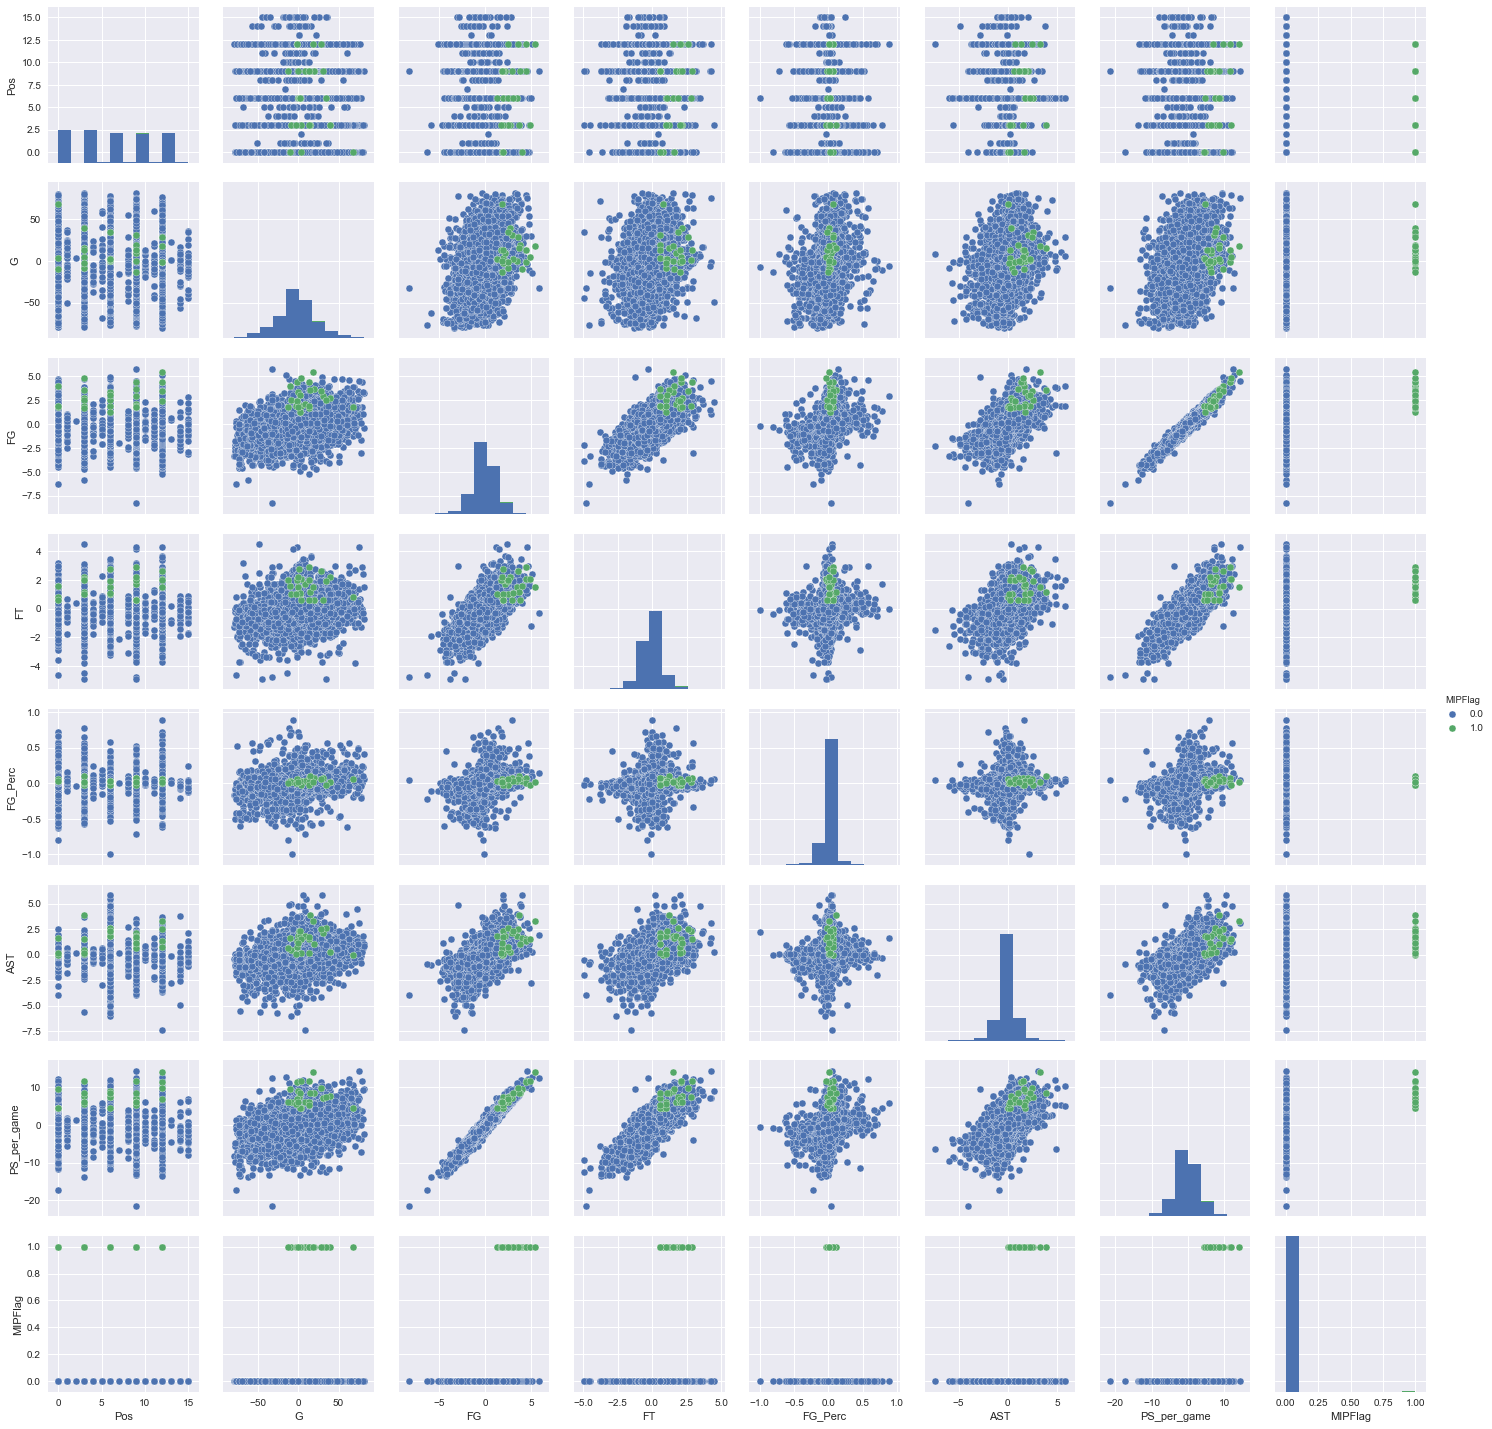

In [89]:
columns_to_test = ['Pos','G', 'FG', 'FT', 'FG_Perc', 
                   'AST',  'PS_per_game' ]
columns_for_pplot = columns_to_test.copy()
columns_for_pplot.append('MIPFlag')
sns.pairplot(full_mip_data_diff[columns_for_pplot], hue='MIPFlag')

### Implement Random Forest.

In [100]:
#Use Random Forest and train on every year except most recent.
from sklearn.ensemble import RandomForestClassifier
#Scale the train features
from sklearn.preprocessing import StandardScaler
features = columns_to_test.copy()
features.append('year_no')
scaler_train = StandardScaler()
scaler_train.fit(full_mip_data_diff[full_mip_data_diff['Season']!=2016][features])
scaled_features_train = scaler_train.transform(full_mip_data_diff[full_mip_data_diff['Season']!=2016][features])
df_feat_train = pd.DataFrame(scaled_features_train, columns=features)
#Scale the test features
scaler_test = StandardScaler()
scaler_test.fit(full_mip_data_diff[full_mip_data_diff['Season']==2016][features])
scaled_features_test = scaler_test.transform(full_mip_data_diff[full_mip_data_diff['Season']==2016][features])
df_feat_test = pd.DataFrame(scaled_features_test, columns=features)

In [101]:
features2 = features.copy()
features2.append('Season')
y = full_mip_data_diff[['Season','MIPFlag']]
X_train = df_feat_train
y_train = y[y['Season']!=2016].drop('Season', axis=1)
X_test = df_feat_test
y_test = y[y['Season']==2016].drop('Season', axis=1)


In [102]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train['MIPFlag'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [103]:
predictions = rfc.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[398   0]
 [  1   0]]
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       398
        1.0       0.00      0.00      0.00         1

avg / total       0.99      1.00      1.00       399



C:\Users\miah.stewart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Random Forest didn't perform. Will now try KNN.

In [104]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train['MIPFlag'])
pred = knn.predict(X_test)
pred_prob = knn.predict_proba(X_test)
print(confusion_matrix(y_test['MIPFlag'], pred))
print(classification_report(y_test['MIPFlag'], pred))

[[396   2]
 [  1   0]]
             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00       398
        1.0       0.00      0.00      0.00         1

avg / total       0.99      0.99      0.99       399



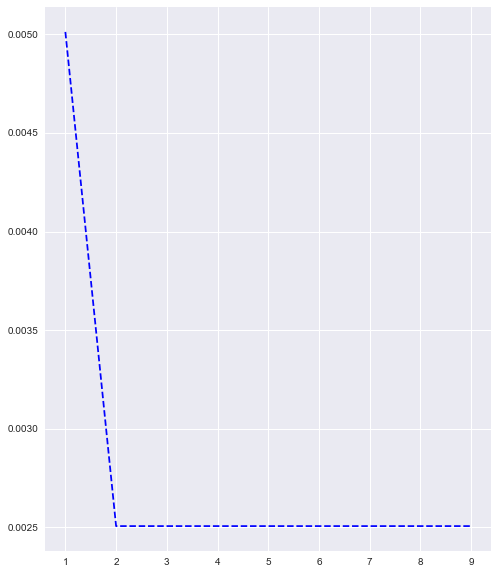

In [17]:
error_rate = []
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train['MIPFlag'])
    pred_i= knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test['MIPFlag']))
plt.figure(figsize=(8,10))
plt.plot(range(1,10), error_rate, color='blue', linestyle='dashed')

In [97]:
compare = full_mip_data_diff[full_mip_data_diff['Season']==2016].copy()
compare['predictedmip'] = pred

### Success! Kind of..

<p>KNN picked out 2 players from the season who looked like they made sufficient improvements in their game; Dennis Schroder and Richaun Holmes, but didn't pick up on the actual award winner - Giannis Antetokounmpo. </p>

In [98]:
compare[compare['predictedmip']==1]

,Player,Season,MIPFlag,Age,Pos,G,MP,MP_per_game,FG,FT,...,eFG_Perc,FT_Perc,TRB,AST,STL,BLK,PS_per_game,USG_Perc,year_no,predictedmip
14542,Dennis Schroder,2016,0.0,23,6,-1.0,864.0,11.2,2.8,1.0,...,0.022,0.064,0.5,1.9,0.0,0.1,6.9,-1.0,4.0,1.0
14308,Richaun Holmes,2016,0.0,23,0,6.0,491.0,7.1,1.8,0.3,...,0.059,0.010,2.9,0.4,0.3,0.2,4.2,0.7,2.0,1.0


In [255]:
compare[compare['Player']=='Giannis Antetokounmpo']

,Player,Season,MIPFlag,Age,Pos,G,MP,MP_per_game,FG,FT,...,eFG_Perc,FT_Perc,TRB,AST,STL,BLK,PS_per_game,USG_Perc,year_no,predictedmip
14082,Giannis Antetokounmpo,2016,1.0,22,9,0.0,22.0,0.3,1.8,2.2,...,0.021,0.046,1.1,1.1,0.4,0.5,6.0,6.0,4.0,0.0


In [109]:
compare[compare['Player']=='Devin Booker']

,Player,Season,MIPFlag,Age,G,MP,FG,FT,FG_Perc,3P_Perc,eFG_Perc,FT_Perc,TRB,AST,STL,BLK,PS_per_game,USG_Perc,year_no,predictedmip
14125,Devin Booker,2016,0.0,20,2.0,622.0,3.0,1.9,0.0,0.02,-0.005,-0.008,0.7,0.8,0.3,0.0,8.3,5.6,2.0,0.0


### Conclusion

<p>I'm happy with how KNN performed given how easy it was to implement and how fast it was performance wise. Will look to try a different approach in the future to hopefully perform better. </p>